# Desarrollo de distintos modelos con machine para predecir la probabilidad de que un cliente pague un préstamo

## Contexto de negocio:
* El equipo de ciencia de datos ha construido un modelo de regresión simpple para predecir la probabilidad en el incumplimiento de préstamos pero resulta ser que el modelo está funcionando mucho peor en producción que en las pruebas.

## Objetivo del trabajo:
* Construir un modelo de probabilidad que sea lo suficientemente certero para ponerlo en producción

## Fases de trabajo:
1. Análisis exploratorio de los datos para determinar las transformaciones de variables apropiadas.
2. Modelamiento con machine learning.
   1. Ajustar algunos modelos simples.
   2. Utilizar validación cruzada para seleccionar el mejor modelo simple.
   3. Combinar diversas técnicas de pre-modelación trabajando con clasificación binaria.
   4. Optimizar el modelo usando regresión logística y varias métricas como ROC/AUC.
   5. Contruir modelos más complejos utilizando validación cruzada.

## Dataset a utilizar:
1. El archivo 'loan_light.csv' contiene los detalles de 5000 préstamos
2. El archivo 'loan_param.xlsx' contiene la descripción de cada covariable

In [143]:
# Importación de libreria
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

### 1. Análisis exploratorio de los datos (EDA)

#### 1.1. Creación de los DataFrame

In [144]:
datos = pd.read_csv('datasets/loan_light.csv')
datos = datos.sample(frac=1)           # Desordenar las filas
datos.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
4429,28000.0,Individual,1403.0,0.0,0.0,10.03,1,B,0.0,326.21,...,4.0,0.0,RENT,36,0.0,0.0,credit_card,2016,0,other
1827,71000.0,Individual,2882.0,0.0,0.0,21.35,2,C,3.0,275.22,...,5.0,0.0,RENT,36,0.0,0.0,medical,2016,0,inspector
4987,60000.0,Individual,7559.0,0.0,0.0,35.31,1,C,0.0,622.71,...,1.0,0.0,OWN,60,0.0,0.0,credit_card,2016,0,president
10,58000.0,Individual,1501.0,0.0,0.0,14.81,5,C,1.0,734.48,...,3.0,1.0,RENT,36,0.0,0.0,credit_card,2016,0,manager
3969,82333.0,Individual,31882.0,0.0,0.0,20.92,8,B,1.0,98.92,...,5.0,0.0,MORTGAGE,36,3.0,0.0,debt_consolidation,2016,0,manager


In [145]:
datos.keys()

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [146]:
df_descripcion = pd.read_excel('datasets/loan_param.xlsx').dropna()
df_descripcion.head()

,BrowseNotesFile,Description
0,loanAmnt,The listed amount of the loan applied for by t...
1,annualInc,The self-reported annual income provided by th...
2,application_type,Indicates whether the loan is an individual ap...
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months


In [147]:
df_descripcion.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


#### 1.2. Visualización con diagrama de barras para mostrar los préstamos pagos y los impagos

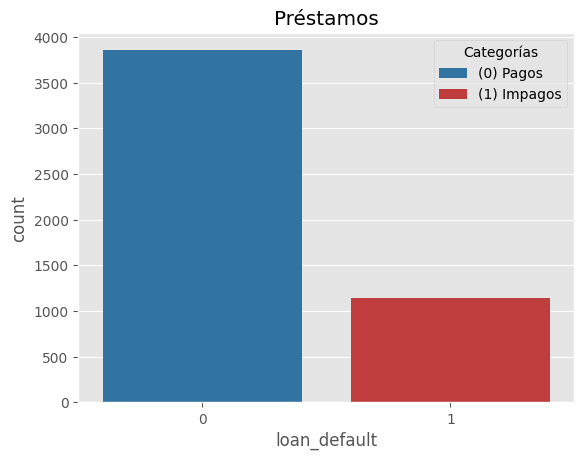

In [148]:
# Creación de una paleta personalizada
paleta = ['#1f77b4', '#d62728']  # Azul para pagos y rojo para impagos

# Creación del gráfico con la paleta personalizada
sns.countplot(x='loan_default', data=datos, palette=paleta)
plt.title('Préstamos')

# Creación de leyenda personalizada
plt.legend(labels=['(0) Pagos', '(1) Impagos'], loc='upper right', title='Categorías')

plt.show()

#### 1.3. Visualización de un histograma con los ingresos anuales

Text(0.5, 0, 'Ingreso anual')

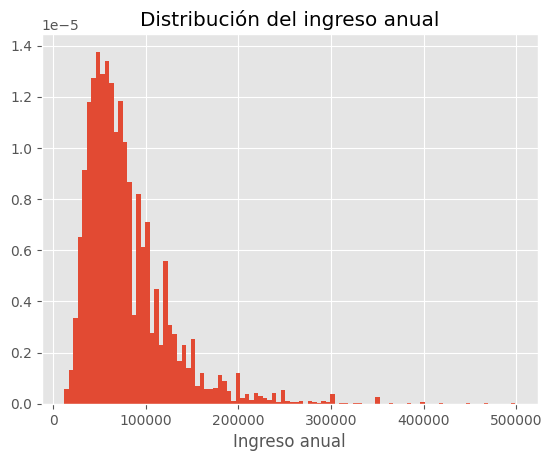

In [149]:
datos.annual_inc.hist(bins=100, density=True)
plt.title('Distribución del ingreso anual')
plt.xlabel('Ingreso anual')

Como los datos están sesgados, se resuelve hacer una transformación logarítmica

Text(0.5, 0, 'ingreso anual')

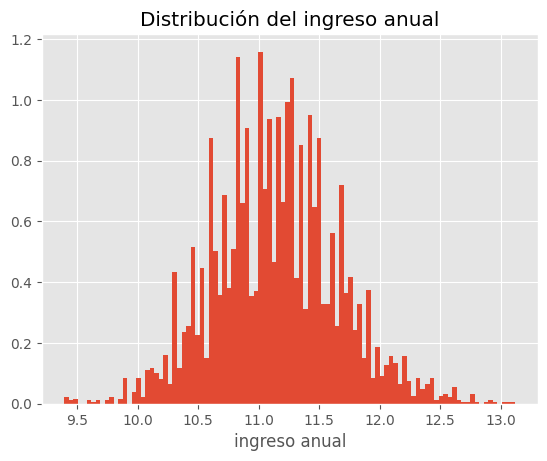

In [150]:
np.log(datos.annual_inc).hist(bins=100, density=True)
plt.title('Distribución del ingreso anual')
plt.xlabel('ingreso anual')

#### 1.4. Observaciones

1.4.1. ¿Es la distribución del ingreso anual diferente entre los aplicantes que no pagaron y los que sí pagaron?

Text(0.5, 1.0, 'Salario anual -- Estatus del préstamo')

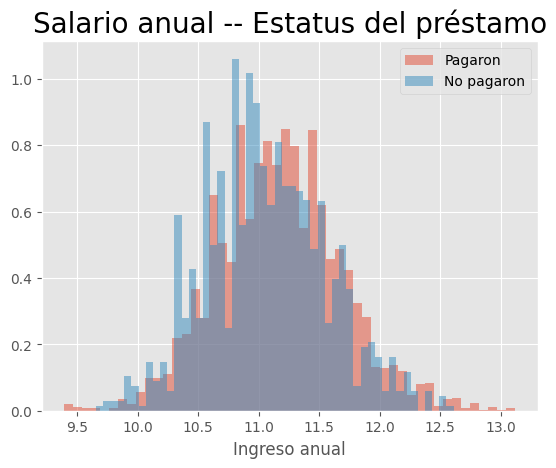

In [151]:
np.log(datos['annual_inc'][datos.loan_default == 0]).hist(bins=50, density=True, alpha=0.5, label='Pagaron')
np.log(datos['annual_inc'][datos.loan_default == 1]).hist(bins=50, density=True, alpha=0.5, label='No pagaron')

plt.xlabel('Ingreso anual')
plt.legend()
plt.title('Salario anual -- Estatus del préstamo', fontsize=20)

1.4.2. Se puede observar que, si bien, arriba de 11.0 se empieza a notar que el ingreso ayuda a incrementar las posibilidades de que paguen el préstamo, no existe una diferencia significativa

#### 1.5. Asociación entre el ingreso anual y las cuotas mensuales

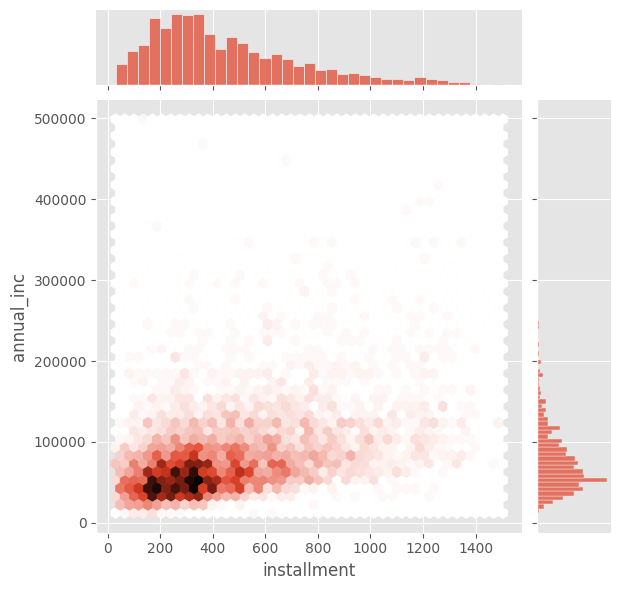

In [152]:
sns.jointplot(x='installment', y='annual_inc', data=datos, kind='hex')

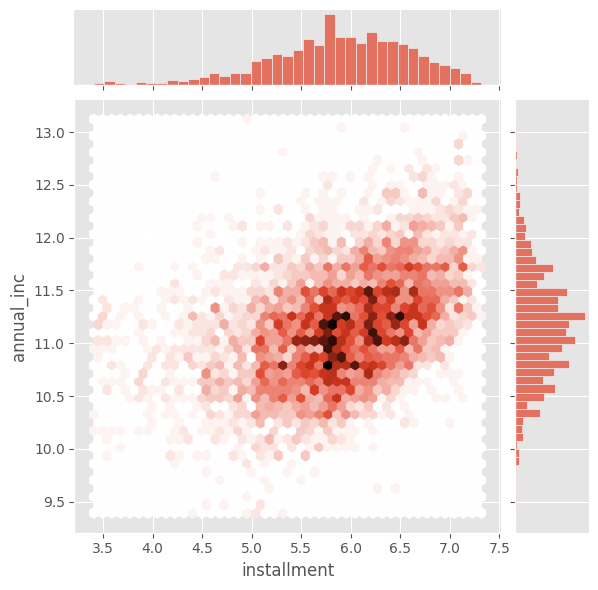

In [153]:
# Debido a que están sesgados, se usará la función logarítmica

sns.jointplot(x=np.log(datos['installment']), y=np.log(datos['annual_inc']), kind='hex')
plt.show()

#### 1.6. Observaciones
* Existe una relación lineal entre los logaritmos de los ingresos anuales y las cuotas mensuales. Esto quiere decir que a medida que aumentan los ingresos anuales, tambien aumenta el monto que aceptan de sus cuotas mensuales.

#### 1.7. Asociación entre el ingreso anual y las cuotas mensuales

* A continuación, se muestran otras figuras que muestran la relación entre covariables numéricas y la probabilidad de impago, así como con el ingreso anual.

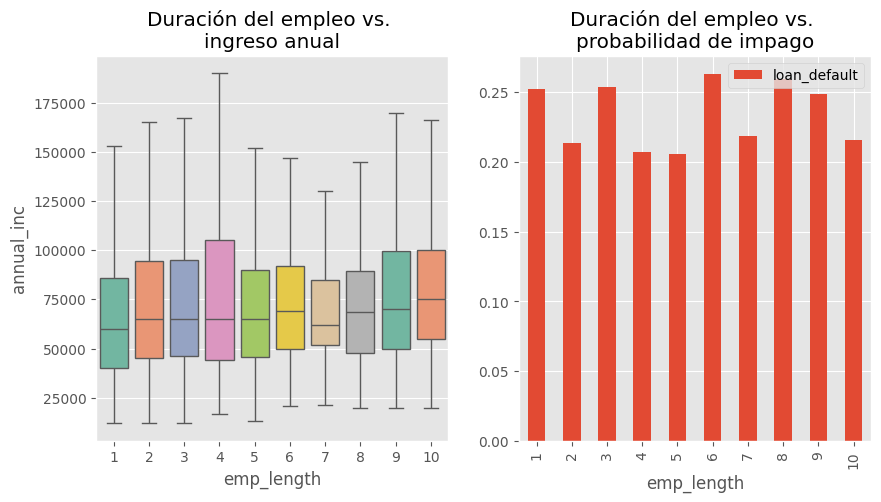

In [154]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x='emp_length', y = 'annual_inc', data = datos, showfliers=False, ax=ax1, palette='Set2') # showfliers=False para que se vea bonito
ax1.set_title("Duración del empleo vs. \ningreso anual")
datos[["emp_length",'loan_default']].groupby("emp_length").mean().plot.bar(rot=90,ax=ax2)
ax2.set_title("Duración del empleo vs. \nprobabilidad de impago")
plt.show()

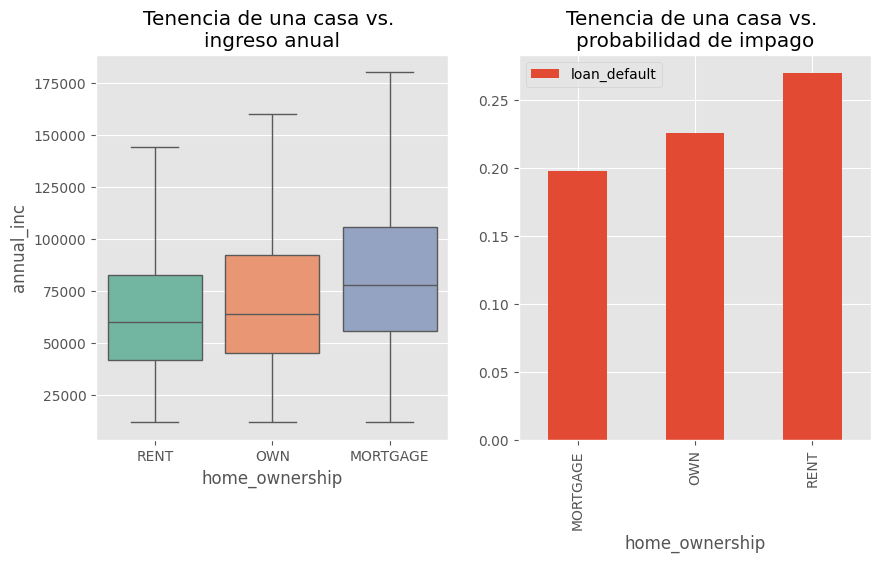

In [155]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership", y="annual_inc", data=datos, showfliers=False, ax =ax1, palette='Set2') #showfliers=False para que se vea bonito
ax1.set_title("Tenencia de una casa vs. \ningreso anual")
datos[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90, ax=ax2)
ax2.set_title("Tenencia de una casa vs. \nprobabilidad de impago")
plt.show()

Y estas son algunas gráficas que muestran la relación entre diversas variables categóricas y la probabilidadde impago.

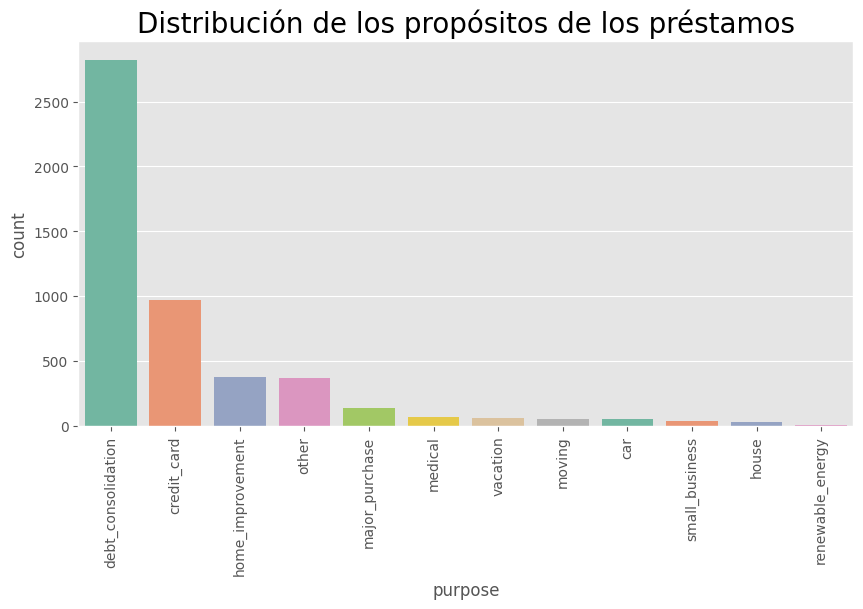

In [156]:
plt.figure(figsize=(10, 5))
datos.emp_length.value_counts()
sns.countplot(x='purpose', order=datos['purpose'].value_counts().index, data=datos, palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribución de los propósitos de los préstamos", fontsize=20)
plt.show()

Text(0.5, 1.0, 'Probabilidad de impago según propósito del préstamo')

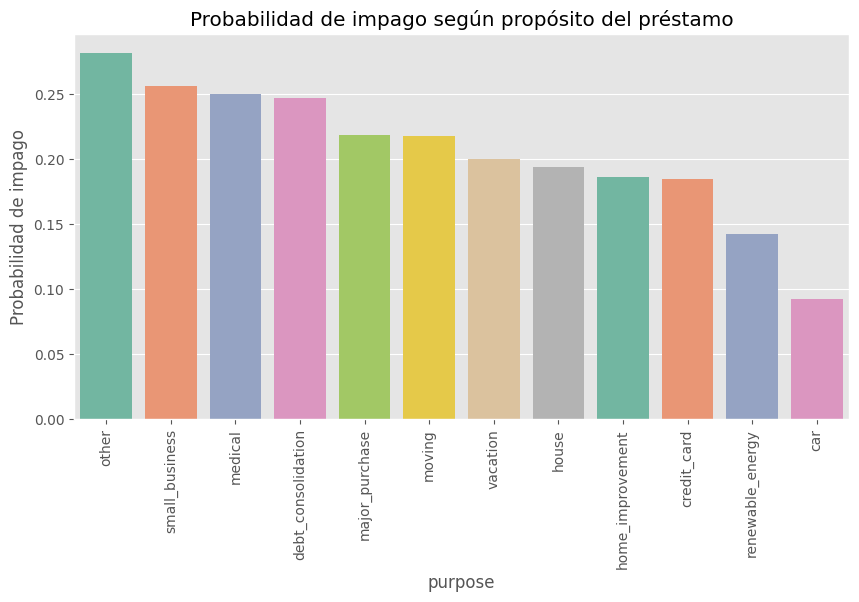

In [157]:
plt.figure(figsize= (10,5))
proposito_impago = datos[["loan_default", "purpose"]].groupby("purpose").mean()
proposito_impago = proposito_impago.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=proposito_impago.index[:30],
y=proposito_impago["loan_default"][:30].values,
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Probabilidad de impago");
plt.title("Probabilidad de impago según propósito del préstamo")

Text(0.5, 1.0, 'Distribución de los trabajos')

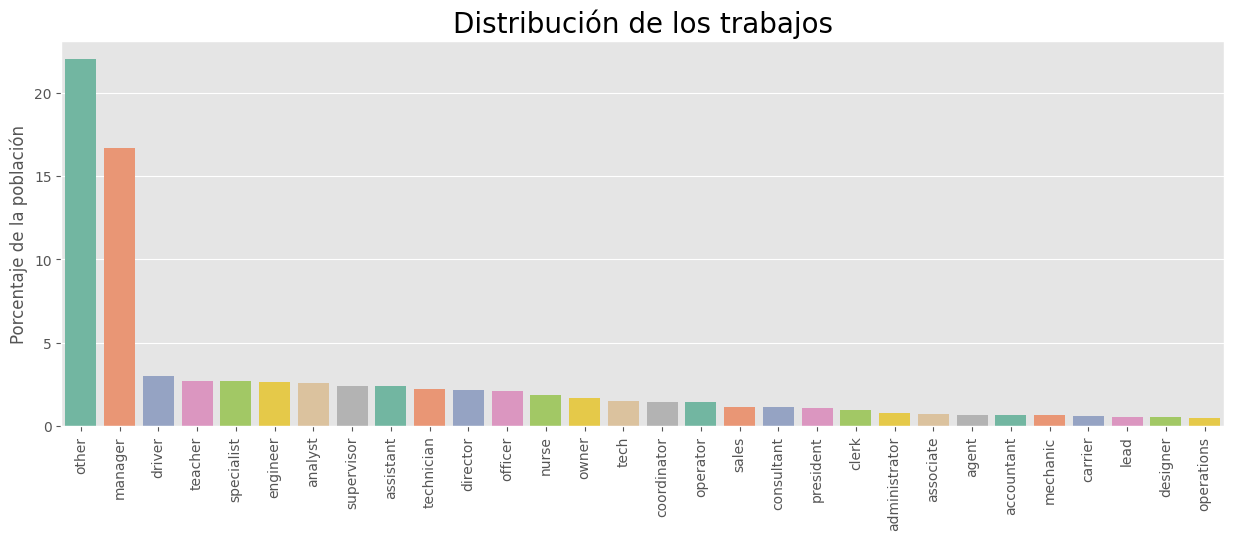

In [158]:
plt.figure(figsize= (15,5))
sns.barplot(x=datos["job"].value_counts()[:30].index.values ,
y=100 * datos.job.value_counts()[:30].values / len(datos),
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Porcentaje de la población")
plt.title("Distribución de los trabajos", fontsize=20)

Text(0.5, 1.0, 'Probabilidad de impago según tipo de trabajo')

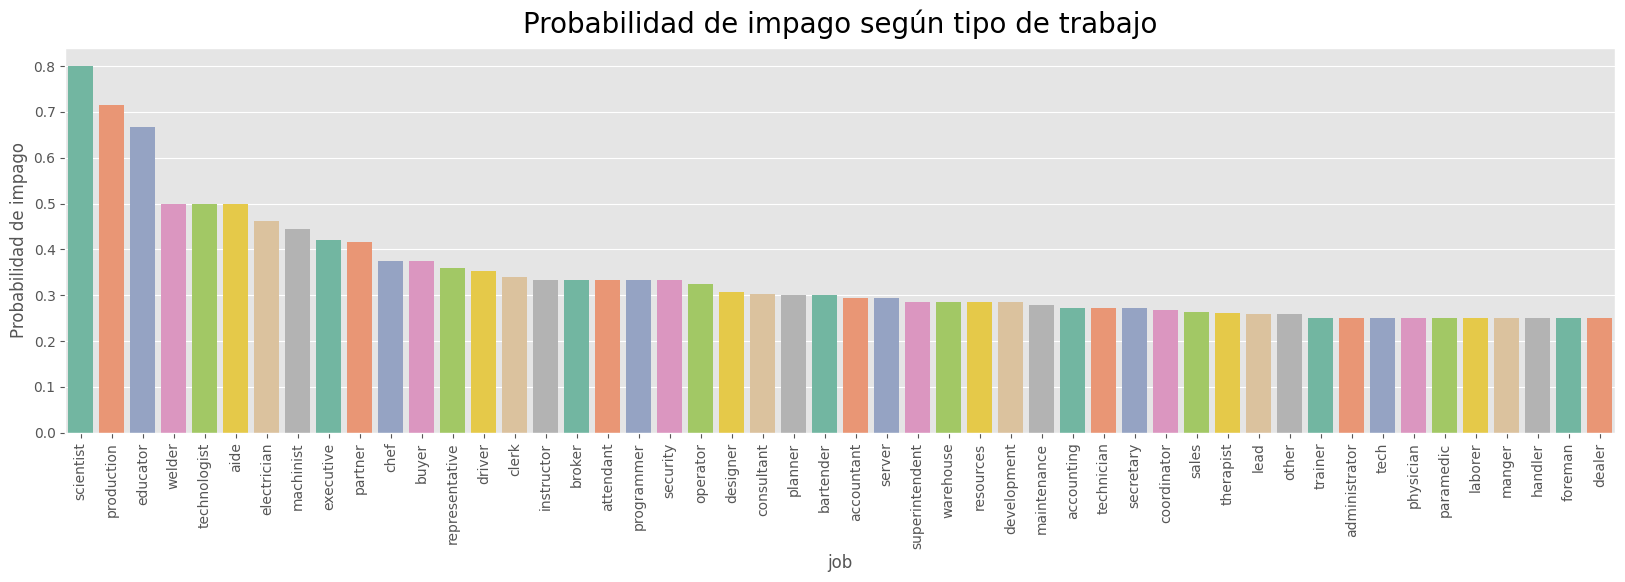

In [159]:
plt.figure(figsize= (20,5))
df_trabajo_impago = datos[["loan_default", "job"]].groupby("job").mean()
df_trabajo_impago = df_trabajo_impago.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_trabajo_impago.index[:50],
y=df_trabajo_impago["loan_default"][:50].values,
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Probabilidad de impago")
plt.title("Probabilidad de impago según tipo de trabajo", fontsize=20,
verticalalignment='bottom')

#### 1.8. Añadiendo una nueva variable
El pago anual que debe el prestatario, como fracción de sus ingresos anuales, es una medida estándar que
se utiliza para evaluar si se debe conceder un préstamo. Definamos una nueva variable “install_income”
que codifique la cuota como una fracción de los ingresos anuales y estudiemos su asociación con las demás
características (“cuota” se dice installment en inglés):

Text(0.5, 0, 'Cuota / Ingresos')

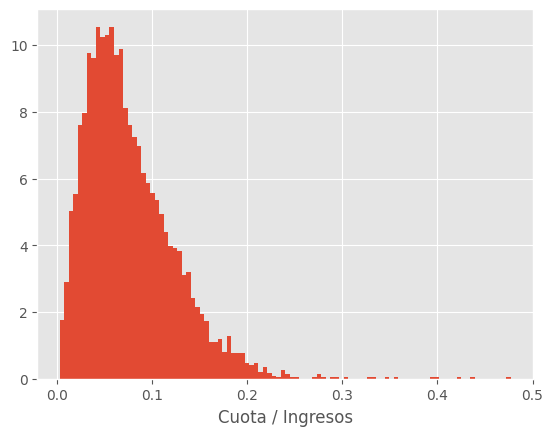

In [160]:
datos['install_income'] = 12 * datos.installment / datos.annual_inc
H = plt.hist(datos['install_income'], bins=100, density=True)
plt.xlabel(r"Cuota / Ingresos")

Para investigar más fácilmente la asociación de esta variable con la probabilidad de impago, se define una nueva covariable llamada install_income_disc que sea una versión discretizada de install_income

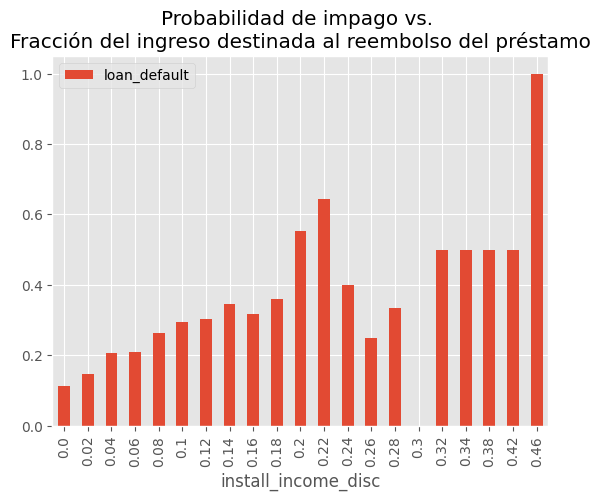

In [161]:
# Discreticemos la variable "install_income" para estudiar la probabilidad de impago como una función de "install_income"
datos["install_income_disc"] = (datos.install_income * 50).astype(int) / 50
# discretización
mean_values = datos[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean()
mean_values.plot(kind='bar', rot=90)
plt.title("Probabilidad de impago vs. \nFracción del ingreso destinada al reembolso del préstamo")
plt.show()
datos = datos.drop(["install_income_disc"], axis=1)
# --> hay una asociación claramente positiva: a medida que la fracción del ingreso, destinada al reembolso del préstamo se incrementa, la probabilidad de impago se incrementa fuertemente

#### 1.9. Matriz de correlación
Se visualiza la matriz de correlación para todas las columnas numéricas usando el comando sns.heatmap()

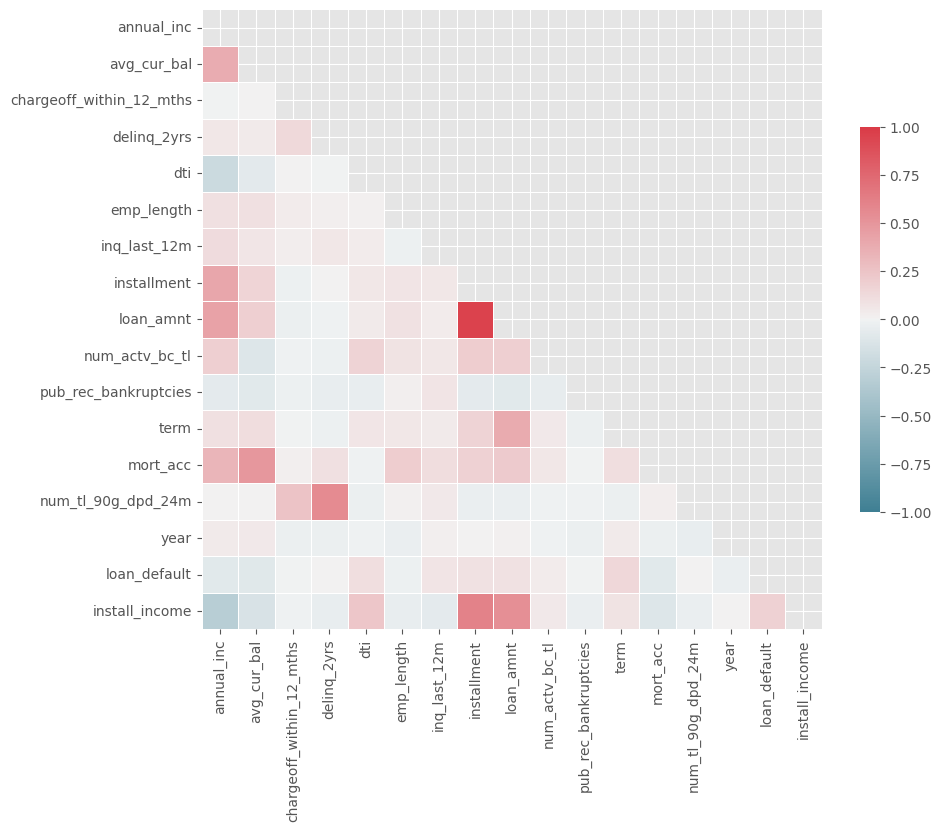

In [162]:
# Filtra solo las columnas numéricas
datos_numericos = datos.select_dtypes(include=[np.number])

# Calcula la matriz de correlación
df_correlacion = datos_numericos.corr()

# Enmascarar la parte superior para efectos de la visualización
mascara = np.zeros_like(df_correlacion, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Dibuja el mapa de calor con la máscara y las dimensiones correctas
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlacion, mask=mascara, vmax=1, vmin=-1, cmap=cmap,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Podemos ver aquí que installment y loan_amnt están altamente correlacionados. En general, podemos
utilizar inicialmente una matriz de correlación como una técnica de selección de variables para eliminar las
que estén extremadamente correlacionadas para evitar la multicolinealidad. No existe un límite científico
para cuando una correlación justifica la eliminación de un rasgo, así que siempre hay que investigar más a
fondo. Piense en ello como una alerta cuando vea parámetros altamente correlacionados y luego investigue la
razón detrás de tal correlación para ver si una de las características puede ser eliminada. Un ejemplo clásico
de características correlacionadas que requieren ser eliminadas serían dos características que muestran la
distancia en millas y kilómetros, respectivamente. Hay una información claramente redundante allí

### Ejercicio 3:
#### 3.1 


### 2. Modelamiento con machine learning
Se construirá un modelo estándar de regresión logística. En general, es importante y extremadamente útil crear primero modelos básicos/simples que puedan ser comparados con modelos más complejos más adelante.

#### 2.1. Regresión logística
Usando la función LogisticRegression() de scikit-learn, se escribe una función que se llame aplicar_regresion_logistica(X,y) que aplica una regresión logística a la matriz de covariables X y
a su variable de respuesta asociada y.

In [163]:
from sklearn.linear_model import LogisticRegression
def aplicar_regresion_logistica(X,y):
    """
    Aplica una regresión logística a la matriz de características X y al resultado, binario y
    """
    clasif = LogisticRegression(solver='lbfgs', tol=10**-4,
    fit_intercept=True,
    multi_class='multinomial').fit(X,y)
    return clasif

#### 3.2.
Creee un modelo básico de regresión logistica para predecir el impago de los préstamos usando solo una característica: install_income. Llame a este modelo modelo1. Use una partición 70/30 de entrenamiento pruebas en los datos.

In [164]:
# Usaremos una partición 70%/30% de entrenamiento/validacion
n_total = len(datos)
n_entrenamiento = int(0.7*n_total)
X, y = datos[["install_income"]], datos.loan_default
X_entrenamiento, y_entrenamiento = X[:n_entrenamiento], y[:n_entrenamiento]
X_pruebas, y_pruebas = X[n_entrenamiento:], y[n_entrenamiento:]

In [165]:
modelo1 = aplicar_regresion_logistica(X_entrenamiento, y_entrenamiento) 
# Ajustando la regresión logística
y_pruebas_pred = modelo1.predict_proba(X_pruebas)[:,1] 
# Hacer predicciones, probabilísticas en el conjunto de pruebas

Ahora que hemos ajustado un modelo, procederemos a evaluar lo “bueno” que es. Los modelos de clasificación
se juzgan de forma diferente a los modelos de regresión lineal. Una herramienta común a la que tendrá que
acostumbrarse es la matriz de confusión. Además, a continuación introduciremos algunas otras métricas
relacionadas con los algoritmos de clasificación. Es importante señalar que estas métricas se aplican a otros
modelos de clasificación, no sólo a la regresión logística.

3.3. Graficar la curva ROC de del modelo1 y hallar el área bajo la curva (AUC)

In [166]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Text(0.5, 1.0, 'Curva ROC -- Modelo de línea base')

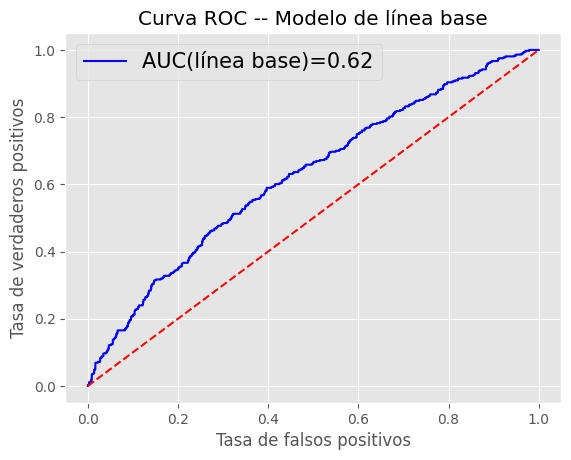

In [167]:
#FPR= False Positive Rate (Tasa de falsos positivos)
#TPR True Positive Rate (Tasa de verdaderos positivos)
fpr, tpr, _ = roc_curve(y_pruebas, y_pruebas_pred) # Calculando FPR y TPR
auc_linea_base = auc(fpr, tpr) # calculando la AUC (área bajo la curva ROC)
plt.plot(fpr, tpr, "b-", label="AUC(línea base)={:2.2f}".format(auc_linea_base))
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("Curva ROC -- Modelo de línea base")

#### Observaciones

* 4.1. Considerando el modelo, este no debería ser el modelo final. Esto se debe a que no hemos explorado la contribución deotras variables, que además de contener información valiosa podrían ser variables de confusión con el efecto percibido de install_income en la variable respuesta. Esta subexplotación de la información se denomina subajuste, underfitting en inglés.

* 4.2. Colocar todas las variables disponibles en el modelo, para aprovechar al máximo nuestra información disponible sería una mala idea. Si ciegamente utilizamos todas las variables en nuestro modelo de ajuste, ocurre un fenómeno llamado sobreajuste. Esto es cuando un modelo estadístico “encaja” demasiado bien en un conjunto particular de datos, que bien puede ser ruidoso y exhibir aleatoriedad y por lo tanto no puede predecir futuras observaciones diferentes de manera confiable. Además de que podría correrse el riesgo de la multicolinealidad.

#### Comentario adicional

En la mayoría de los casos, se trabajará con conjuntos de datos con muchas características que tienen cada una su propia distribución. Por lo general, se dedica una gran cantidad de tiempo a la selección de características y muchos modelos se entrenan durante este tiempo. Es extremadamente raro que simplemente se conecten todas las características y se calibren una sola vez para obtener el modelo óptimo. 

Hay muchas técnicas diferentes asociadas con la selección de características y una mirada exhaustiva a todas ellas está fuera del alcance de este caso. Para simplificar, demostraremos el entrenamiento y las pruebas de los modelos en modelos de una sola característica y luego pasaremos directamente a los modelos de múltiples características para mostrar los numerosos escenarios posibles que puede encontrar. En la vida real aplicaríamos la validación cruzada en numerosos subconjuntos de características basándonos en el conocimiento que tengamos del tema particular del conjunto de datos para ver qué conjunto de características optimiza realmente el modelo que estamos tratando de crear.

#### Validación cruzada
A continuación se muestra un ejemplo de validación cruzada de 5 folds:
Hagámoslo con código. El siguiente código muestra los 5 folds diferentes usados en un ejercicio estándar de
validación cruzada. Para hacerlo funcionar, use la función StratifiedKFold() de scikit-learn:

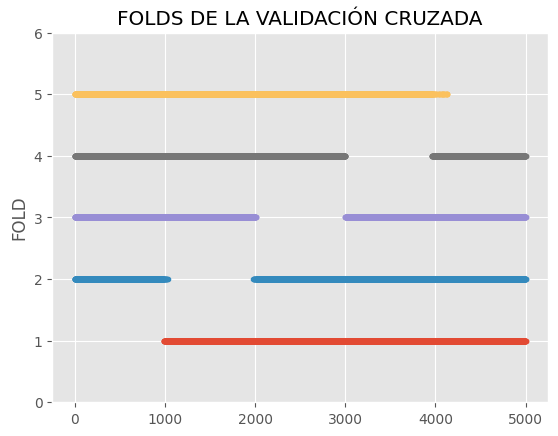

In [168]:
skf = StratifiedKFold(n_splits=5)
for k, (indice_entrenamiento, indice_pruebas) in enumerate( skf.split(X, y) ):
    plt.plot(indice_entrenamiento, [k+1 for _ in indice_entrenamiento], ".")
    plt.ylim(0,6)
    plt.ylabel("FOLD")
    plt.title("FOLDS DE LA VALIDACIÓN CRUZADA")

El siguiente código define la función calcular_AUC(X, y, indice_entrenamiento, indice_pruebas), la cual calcula el AUC de un modelo entrenado con indice_entrenamiento e indice_pruebas.

In [169]:
def calcular_AUC(X, y, indice_entrenamiento, indice_pruebas):
    """
    caracteristicas, variable dependiente: X, y
    particion del conjunto de datos: indice_entrenamiento, indice_pruebas
    """
    X_entrenamiento, y_entrenamiento = X.iloc[indice_entrenamiento], y.iloc[indice_entrenamiento]
    X_pruebas, y_pruebas = X.iloc[indice_pruebas], y.iloc[indice_pruebas]
    clf = aplicar_regresion_logistica(X_entrenamiento, y_entrenamiento)
    probab_impago_pruebas = clf.predict_proba(X_pruebas)[:,1]
    fpr, tpr, _ = roc_curve(y_pruebas, probab_impago_pruebas)
    auc_puntaje = auc(fpr, tpr)
    return auc_puntaje, fpr, tpr

Ejercicio 5. Con la ayuda de la función calcular_AUC que se definió anteriormente, escriba una función llamada cross_validation_AUC(X,y,nfold) que haga una validación cruzada de 10 folds y genere una lista que
contenga el área bajo la curva para cada fold de la validación cruzada.

In [170]:
def cross_validation_AUC(X,y, nfold=10):
    """
    use una validación cruzada de n folds para calcular las AUC estimadas
    """
    skf = StratifiedKFold(n_splits=nfold) # Cree una partición para hacer validación cruzada
    auc_lista = [] # Esta lista contiene las AUC estimadas asociadas a cada fold
    for k, (indice_entrenamiento, indice_pruebas) in enumerate( skf.split(X, y) ):
        auc_puntaje, _, _ = calcular_AUC(X, y, indice_entrenamiento, indice_pruebas)
        auc_lista.append(auc_puntaje)
        return auc_lista

Ahora vamos a estimar y comparar, a través de validación cruzada, el desempeño de todos los modelos simples que solamente usan una sola característica numérica como input. Como se dijo en la sección de EDA, usaremos la transformación logarítmica para las variables anual_income, loan_amount y avg_cur_bal.

In [171]:
# Extraigamos solo las características numéricas (o sea, las no categóricas)
numericas = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
datos_numericas = datos.select_dtypes(include=numericas)
datos_numericas = datos_numericas.drop(["installment", "year"], axis=1)
# Usando una escala logarítmica en los casos apropiados
datos_numericas["annual_inc"] = np.log10(datos_numericas["annual_inc"])
datos_numericas["loan_amnt"] = np.log10(datos_numericas["loan_amnt"])
datos_numericas["avg_cur_bal"] = np.log10(1.+datos_numericas["avg_cur_bal"])

Calculemos las AUC estimadas con validación cruzada para cada uno de los modelos de una sola variable:

In [172]:
modelos_desempeno = pd.DataFrame({}) # Este DataFrame contendrá los estimados de las AUC
for llave in datos_numericas.keys():
    if llave == "loan_default": continue
    X_completo, y_completo = datos_numericas[[llave]], datos_numericas.loan_default
    auc_lista = cross_validation_AUC(X_completo, y_completo, nfold=10)
    modelos_desempeno["SIMPLE:" + llave] = auc_lista

Ejercicio 6: Construya un boxplot (diagrama de cajas) que muestre la distribución de los puntajes de validación cruzada de cada variable (recuerde que cada variable tiene 10 puntajes). ¿Qué variable tiene el mayor/menor poder predictivo?

In [173]:
def dibujar_boxplot_ordenado(df_modelo):
    """
    Muestre una lista de boxplots, ordenados por los valores medianos
    """
    df = df_modelo[df_modelo.median().sort_values().index]
    sns.boxplot(x="variable", y="value", data=pd.melt(df), showfliers=False)
    plt.xticks(rotation=90)

In [174]:
modelos_desempeno

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:install_income
0,0.581788,0.582299,0.503886,0.476684,0.577493,0.485774,0.572539,0.552882,0.531349,0.517453,0.578197,0.579391,0.493432,0.615649


Text(0, 0.5, 'AUC')

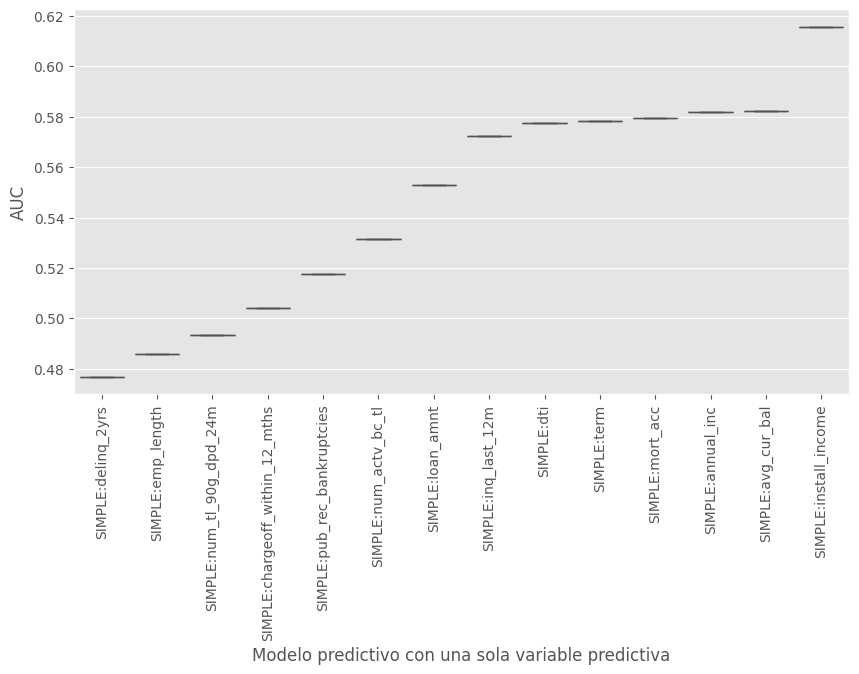

In [175]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola variable predictiva")
plt.ylabel("AUC")

Ejercicio 7: Consideremos el modelo que consiste en utilizar todas las características numéricas (y ninguna de las características categóricas). Lleve a cabo un análisis de validación cruzada de 10 folds para determinar si este modelo tiene un mejor rendimiento predictivo que el mejor modelo de una sola característica. Vuelva a utilizar el método del gráfico de cajas como hicimos en el ejercicio 6.

In [176]:
X_completo, y_completo = datos_numericas.drop(["loan_default"], axis=1), datos_numericas.loan_default
auc_lista = cross_validation_AUC(X_completo, y_completo)
modelos_desempeno["TODAS_LAS_NUMERICAS"] = auc_lista
modelos_desempeno

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:install_income,TODAS_LAS_NUMERICAS
0,0.581788,0.582299,0.503886,0.476684,0.577493,0.485774,0.572539,0.552882,0.531349,0.517453,0.578197,0.579391,0.493432,0.615649,0.669121


Text(0, 0.5, 'AUC')

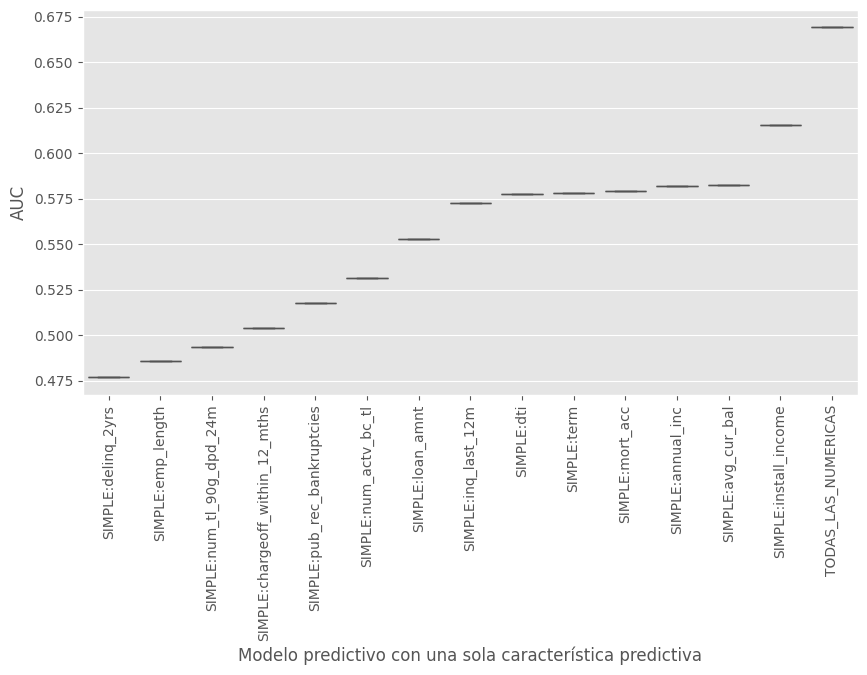

In [177]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola característica predictiva")
plt.ylabel("AUC")

Vemos que el modelo combinado funciona mejor que el mejor modelo de una sola característica. Por lo tanto, seguiremos adelante con él durante el resto de este caso. Nótese, sin embargo, que la mejor práctica consistiría en añadir iterativamente características al mejor modelo de una sola característica hasta que lleguemos a un punto en el que no haya una mejora significativa, en lugar de lanzar todas las características de una sola vez. Le aconsejamos que use este enfoque más cauteloso cuando construya sus propios modelos.

#### Incorporando las variables categóricas
La calificación de un préstamo (es decir, la característica que le asigna una calificadora de créditos) no ha sido usada hasta ahora. Esta es la distribución de esta variable (grade):

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'B'),
  Text(1, 0, 'C'),
  Text(2, 0, 'D'),
  Text(3, 0, 'A'),
  Text(4, 0, 'E'),
  Text(5, 0, 'G'),
  Text(6, 0, 'F')])

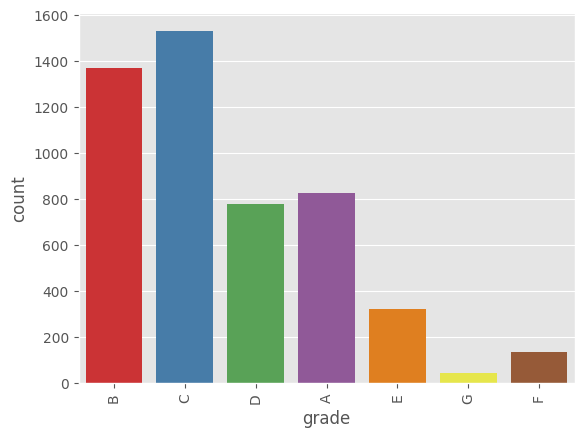

In [178]:
datos.emp_length.value_counts()
sns.countplot(x='grade', data = datos, palette='Set1')
plt.xticks(rotation=90)

Ejercicio 8
8.1. Use pandas.get_dummies() para transformar la variable en una versión one-hot-encoded

In [179]:
# Convierta aa one-hot-encoding para incorporar la calificación ("grade"), que es categórica
calif_categ = pd.get_dummies(datos['grade'], prefix = "grade", drop_first=True)
calif_categ.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
4429,True,False,False,False,False,False
1827,False,True,False,False,False,False
4987,False,True,False,False,False,False
10,False,True,False,False,False,False
3969,True,False,False,False,False,False


In [180]:
# Convertir los valores de True/False a 1/0 
calif_categ = calif_categ.applymap(lambda x: 1 if x else 0)

calif_categ.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
4429,1,0,0,0,0,0
1827,0,1,0,0,0,0
4987,0,1,0,0,0,0
10,0,1,0,0,0,0
3969,1,0,0,0,0,0


8.2. Añada esta característica al modelo totalmente numérico de antes e investigue si esto conduce a un aumento significativo de la exactitud de la predicción

In [181]:
X_calif = pd.concat([X_completo, calif_categ],axis=1)
X_calif.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,install_income,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
4429,4.447158,3.147367,0.0,0.0,10.03,1,0.0,4.000000,4.0,0.0,36,0.0,0.0,0.139804,1,0,0,0,0,0
1827,4.851258,3.459845,0.0,0.0,21.35,2,3.0,3.903090,5.0,0.0,36,0.0,0.0,0.046516,0,1,0,0,0,0
4987,4.778151,3.878522,0.0,0.0,35.31,1,0.0,4.447158,1.0,0.0,60,0.0,0.0,0.124542,0,1,0,0,0,0
10,4.763428,3.176670,0.0,0.0,14.81,5,1.0,4.329398,3.0,1.0,36,0.0,0.0,0.151961,0,1,0,0,0,0
3969,4.915574,4.503559,0.0,0.0,20.92,8,1.0,3.477121,5.0,0.0,36,3.0,0.0,0.014418,1,0,0,0,0,0


In [182]:
auc_lista = cross_validation_AUC(X_calif, y_completo)
modelos_desempeno["TODAS_NUMERICAS_Y_CALIFICACION"] = auc_lista

Text(0, 0.5, 'AUC')

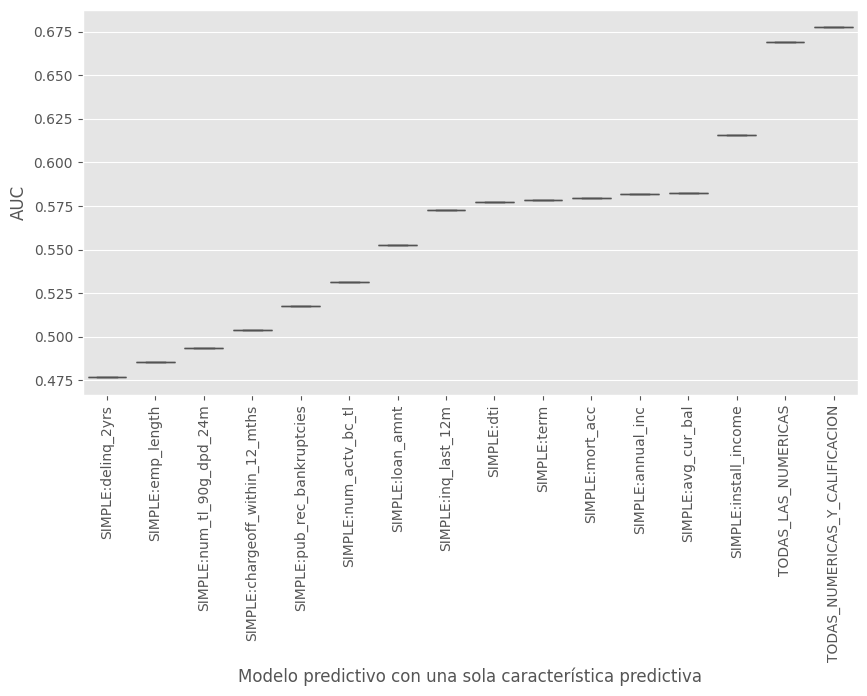

In [183]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola característica predictiva")
plt.ylabel("AUC")

La diferencia parece significativa pues el boxplot del modelo actualizado casi no se solapa con el del modelo anterior

Ejercicio 9:
Investigue si la variable categórica job aporta algún valor predictivo cuando se añade al mejor modelo actual. De nuevo, puede que quiera usar un esquema one-hot-encoding.

Text(0.5, 1.0, 'Tasa de impago por tipo de empleo')

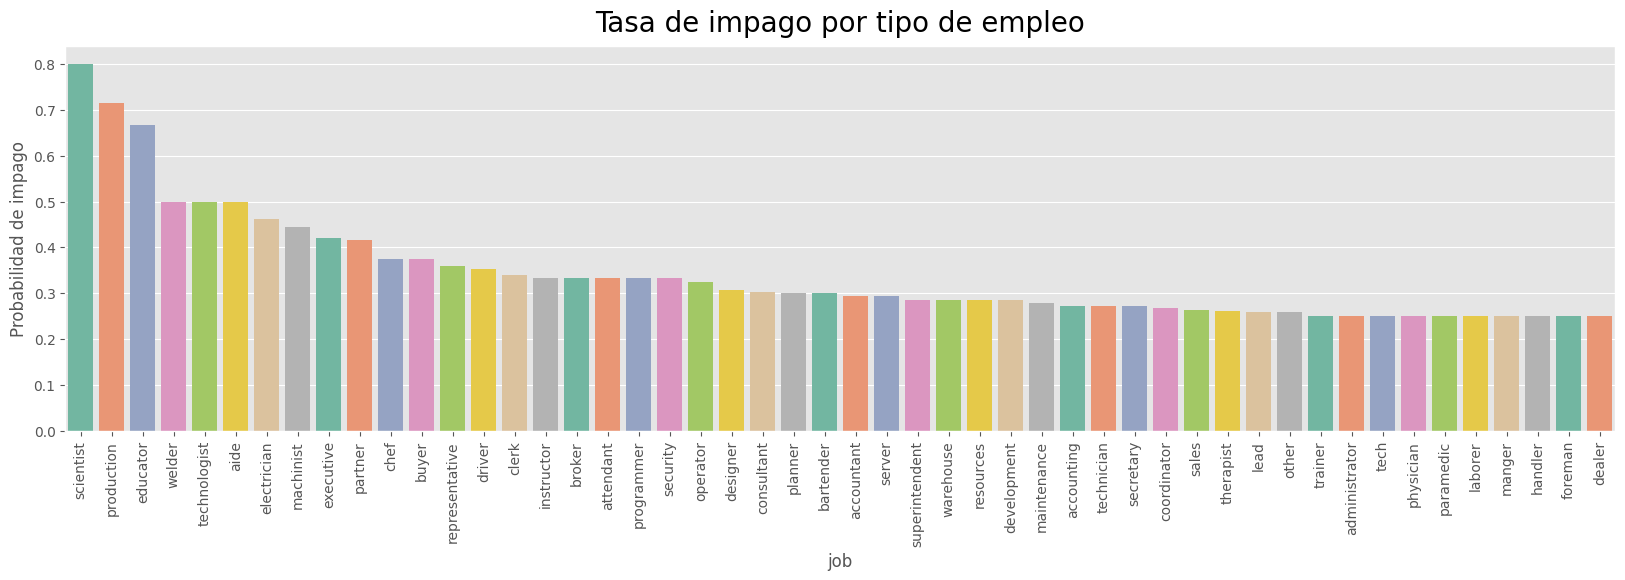

In [184]:
plt.figure(figsize= (20,5))
df_trabajo_impago = datos[["loan_default", "job"]].groupby("job").mean()
df_trabajo_impago = df_trabajo_impago.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_trabajo_impago.index[:50],
y=df_trabajo_impago["loan_default"][:50].values,
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Probabilidad de impago")
plt.title("Tasa de impago por tipo de empleo", fontsize=20, verticalalignment='bottom')

In [185]:
# Convertimos a one-hot-encoding para incorporar la variable "purpose", que es categórica
trabajo_categ = pd.get_dummies(datos['job'], prefix = "job", drop_first=True)

# Asegurarse de que los valores sean 1/0 en lugar de True/False
trabajo_categ = trabajo_categ.applymap(lambda x: 1 if x else 0)

In [186]:
X_calif_trabajo = pd.concat([X_calif,trabajo_categ],axis=1)
X_calif_trabajo.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,...,job_technician,job_technologist,job_teller,job_therapist,job_trainer,job_underwriter,job_vp,job_warehouse,job_welder,job_worker
4429,4.447158,3.147367,0.0,0.0,10.03,1,0.0,4.000000,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1827,4.851258,3.459845,0.0,0.0,21.35,2,3.0,3.903090,5.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4987,4.778151,3.878522,0.0,0.0,35.31,1,0.0,4.447158,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
10,4.763428,3.176670,0.0,0.0,14.81,5,1.0,4.329398,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3969,4.915574,4.503559,0.0,0.0,20.92,8,1.0,3.477121,5.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
import pandas as pd

# Ejemplo de datos
datos = pd.DataFrame({
    'job': ['teacher', 'engineer', 'doctor', 'artist', 'engineer']
})

# Convertir la columna 'job' a categórica
datos['job'] = datos['job'].astype('category')

# Convertir a one-hot encoding
trabajo_categ = pd.get_dummies(datos['job'], prefix="job", drop_first=True)

# Asegurarse de que los valores sean 1/0 en lugar de True/False
trabajo_categ = trabajo_categ.applymap(lambda x: 1 if x else 0)

# Imprimir el resultado final
print(trabajo_categ)


   job_doctor  job_engineer  job_teacher
0           0             0            1
1           0             1            0
2           1             0            0
3           0             0            0
4           0             1            0


In [188]:
X_calif_trabajo.keys()
# --> 138 características

Index(['annual_inc', 'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_2yrs',
       'dti', 'emp_length', 'inq_last_12m', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies',
       ...
       'job_technician', 'job_technologist', 'job_teller', 'job_therapist',
       'job_trainer', 'job_underwriter', 'job_vp', 'job_warehouse',
       'job_welder', 'job_worker'],
      dtype='object', length=138)

In [189]:
auc_lista = cross_validation_AUC(X_calif_trabajo, y_completo)
modelos_desempeno["TODAS_LAS_NUMERICAS_CON_CALIFICACION_TRABAJO"] = auc_lista

Text(0, 0.5, 'AUC')

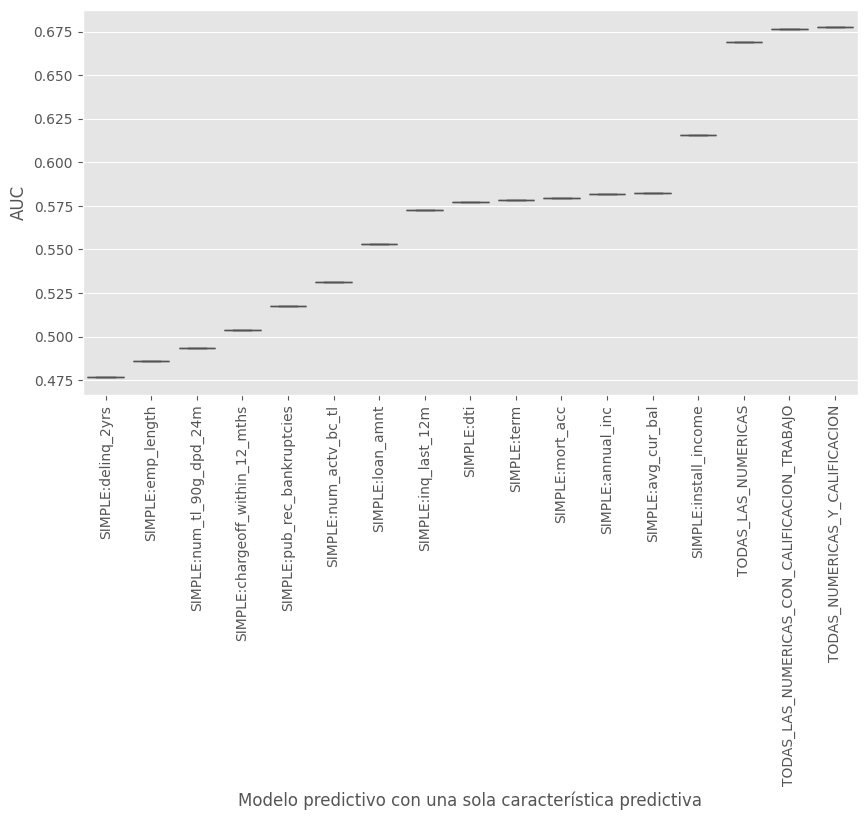

In [190]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola característica predictiva")
plt.ylabel("AUC")

#### Observaciones
Podemos ver que los boxplots se superponen significativamente, por lo que no hay un beneficio discernible. Podemos repetir este proceso con otras variables categóricas para construir iterativamente el modelo más simple posible.

#### Conclusiones
En este caso, primero exploramos el conjunto de datos de préstamos y encontramos las asociaciones de una sola variable entre las características disponibles y la tasa de impago. También descubrimos qué características requerían transformaciones (por ejemplo, la transformación logarítmica). Una vez que empezamos a construir los modelos, comenzamos con enfoques de regresiones logísticas muy
simples; estos modelos de referencia fueron útiles para evaluar rápidamente el poder de predicción de cada variable individual. A continuación, empleamos validación cruzada para construir modelos más complejos, explotando a menudo las interacciones entre las diferentes características. Dado que el conjunto de datos de préstamos contiene un gran número de covariables, el uso de la validación cruzada fue crucial para evitar el exceso de ajuste, elegir el número correcto de características y, en última instancia, elegir un modelo
apropiado que equilibrara la complejidad con la precisión.

#### Puntos clave
La validación cruzada es una técnica robusta y flexible para evaluar el rendimiento predictivo de los modelos estadísticos. Es especialmente útil en entornos de *big data* en los que el número de características es grande en comparación con el número de observaciones. Cuando se utiliza adecuadamente, la validación cruzada es un método poderoso para elegir un modelo con la complejidad correcta y el mejor rendimiento predictivo. Recuerde que la regresión logística es sólo uno de los muchos algoritmos de clasificación y que los principios de la validación cruzada no se limitan sólo a este caso. De hecho, recomendamos mucho utilizar la validación cruzada también para sus modelos de regresión lineal para evitar el sobreajuste.